In [ ]:
# !pip install xgboost
!pip install bayesian-optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime,timedelta
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score



In [2]:
df = pd.read_csv('dataset\irradiance_dataset')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Acer\AppData\Local\Temp\ipykernel_12948\1717908015.py:1: SyntaxWarning: invalid escape sequence '\i'
  df = pd.read_csv('dataset\irradiance_dataset')


,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear,cluster,distance_to_centroid,is_outlier
0,0.0,91.01,15.32,19.39,2022032700,0,6,1,3,2022,86,1,0.528091,False
1,0.0,90.96,15.18,19.24,2022032701,1,6,1,3,2022,86,1,0.390174,False
2,0.0,90.93,14.88,18.99,2022032702,2,6,1,3,2022,86,1,0.259482,False
3,0.0,90.92,14.68,18.72,2022032703,3,6,1,3,2022,86,1,0.155451,False
4,0.0,90.95,14.48,18.50,2022032704,4,6,1,3,2022,86,1,0.150793,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ALLSKY_SFC_SW_DWN     20544 non-null  float64
 1   PS                    20544 non-null  float64
 2   QV2M                  20544 non-null  float64
 3   T2M                   20544 non-null  float64
 4   time                  20544 non-null  int64  
 5   hour                  20544 non-null  int64  
 6   dayofweek             20544 non-null  int64  
 7   quarter               20544 non-null  int64  
 8   month                 20544 non-null  int64  
 9   year                  20544 non-null  int64  
 10  dayofyear             20544 non-null  int64  
 11  cluster               20544 non-null  int64  
 12  distance_to_centroid  20544 non-null  float64
 13  is_outlier            20544 non-null  bool   
dtypes: bool(1), float64(5), int64(8)
memory usage: 2.1 MB


In [4]:
df['datetime'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
df.head()

,ALLSKY_SFC_SW_DWN,PS,QV2M,T2M,time,hour,dayofweek,quarter,month,year,dayofyear,cluster,distance_to_centroid,is_outlier,datetime
0,0.0,91.01,15.32,19.39,2022032700,0,6,1,3,2022,86,1,0.528091,False,2022-03-27 00:00:00
1,0.0,90.96,15.18,19.24,2022032701,1,6,1,3,2022,86,1,0.390174,False,2022-03-27 01:00:00
2,0.0,90.93,14.88,18.99,2022032702,2,6,1,3,2022,86,1,0.259482,False,2022-03-27 02:00:00
3,0.0,90.92,14.68,18.72,2022032703,3,6,1,3,2022,86,1,0.155451,False,2022-03-27 03:00:00
4,0.0,90.95,14.48,18.50,2022032704,4,6,1,3,2022,86,1,0.150793,False,2022-03-27 04:00:00


In [5]:
new_df = df[['datetime','ALLSKY_SFC_SW_DWN']]
new_df = new_df.set_index('datetime')
new_df.head()

,ALLSKY_SFC_SW_DWN
datetime,
2022-03-27 00:00:00,0.0
2022-03-27 01:00:00,0.0
2022-03-27 02:00:00,0.0
2022-03-27 03:00:00,0.0
2022-03-27 04:00:00,0.0


<Axes: xlabel='datetime'>

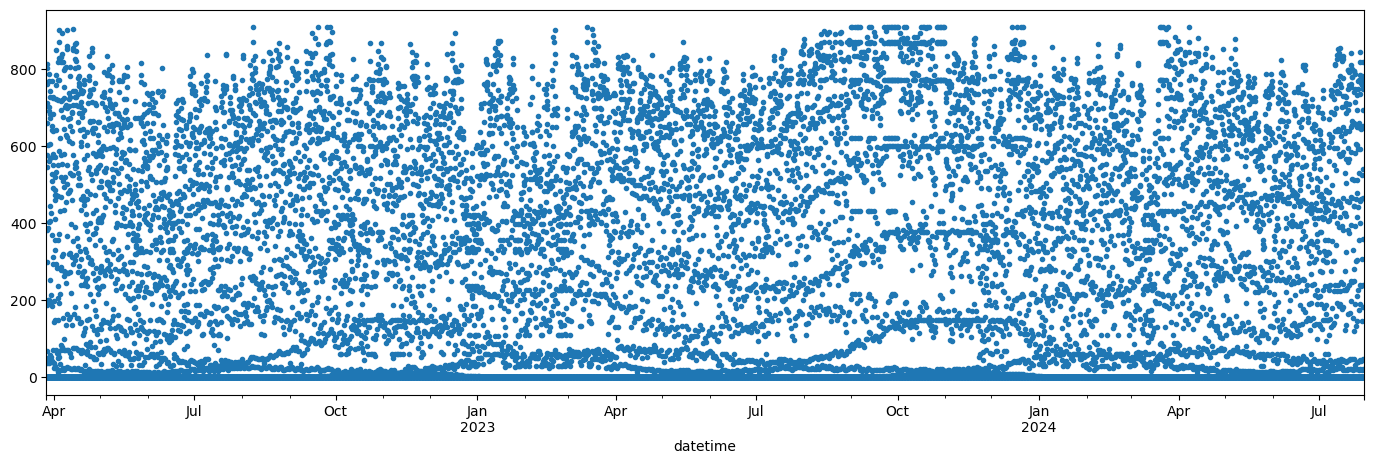

In [6]:
new_df['ALLSKY_SFC_SW_DWN'].plot(style='.', figsize=(17,5))


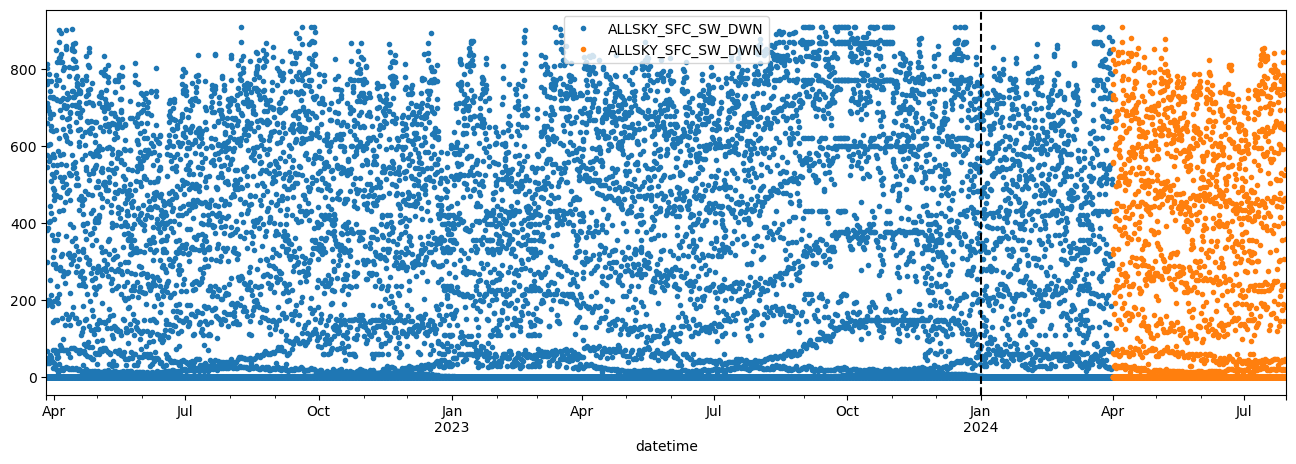

In [7]:
train = new_df.loc[new_df.index < '04-01-2024']
test = new_df.loc[new_df.index >= '04-01-2024']

fig, ax = plt.subplots(figsize=(16,5))
train.plot(ax=ax , label='train',style='.')
test.plot(ax=ax, label='test',style='.')
ax.axvline('01-01-2024',color='black',ls='--')
plt.show()

In [8]:
def create_features(df):
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  return df

In [9]:
data_df = create_features(new_df)
data_df.head()

,ALLSKY_SFC_SW_DWN,hour,dayofweek,quarter,month,year,dayofyear
datetime,,,,,,,
2022-03-27 00:00:00,0.0,0,6,1,3,2022,86
2022-03-27 01:00:00,0.0,1,6,1,3,2022,86
2022-03-27 02:00:00,0.0,2,6,1,3,2022,86
2022-03-27 03:00:00,0.0,3,6,1,3,2022,86
2022-03-27 04:00:00,0.0,4,6,1,3,2022,86


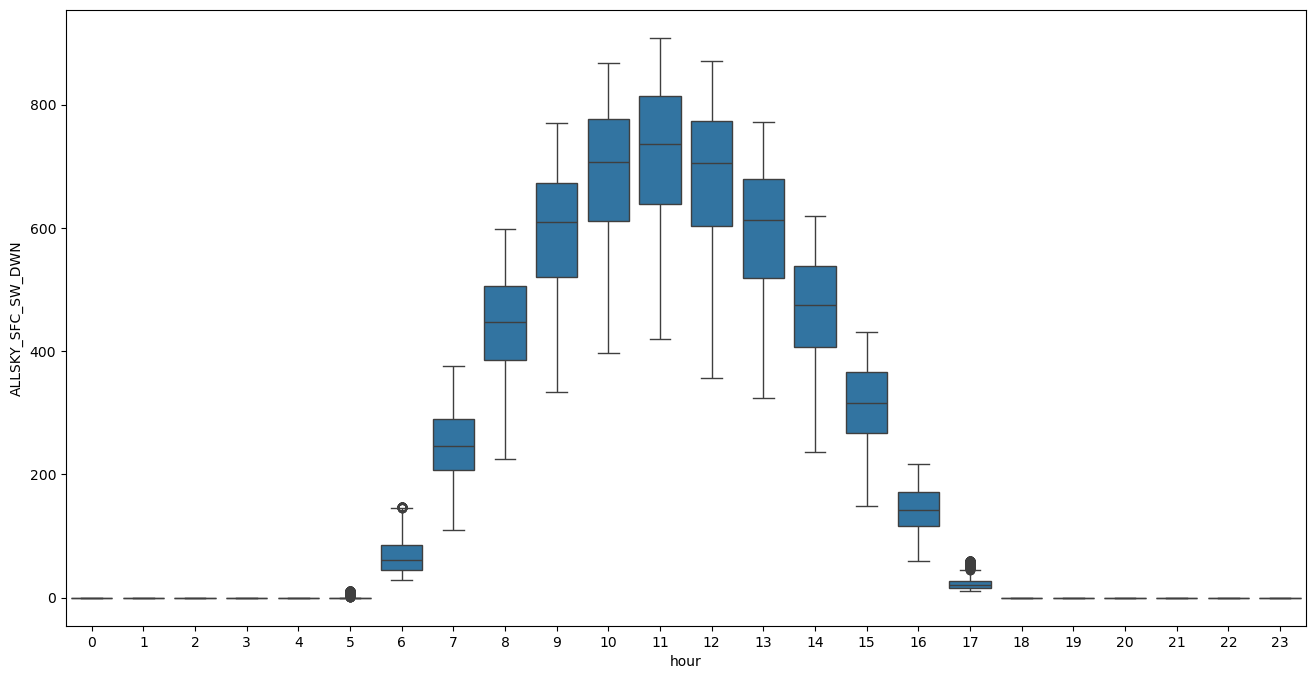

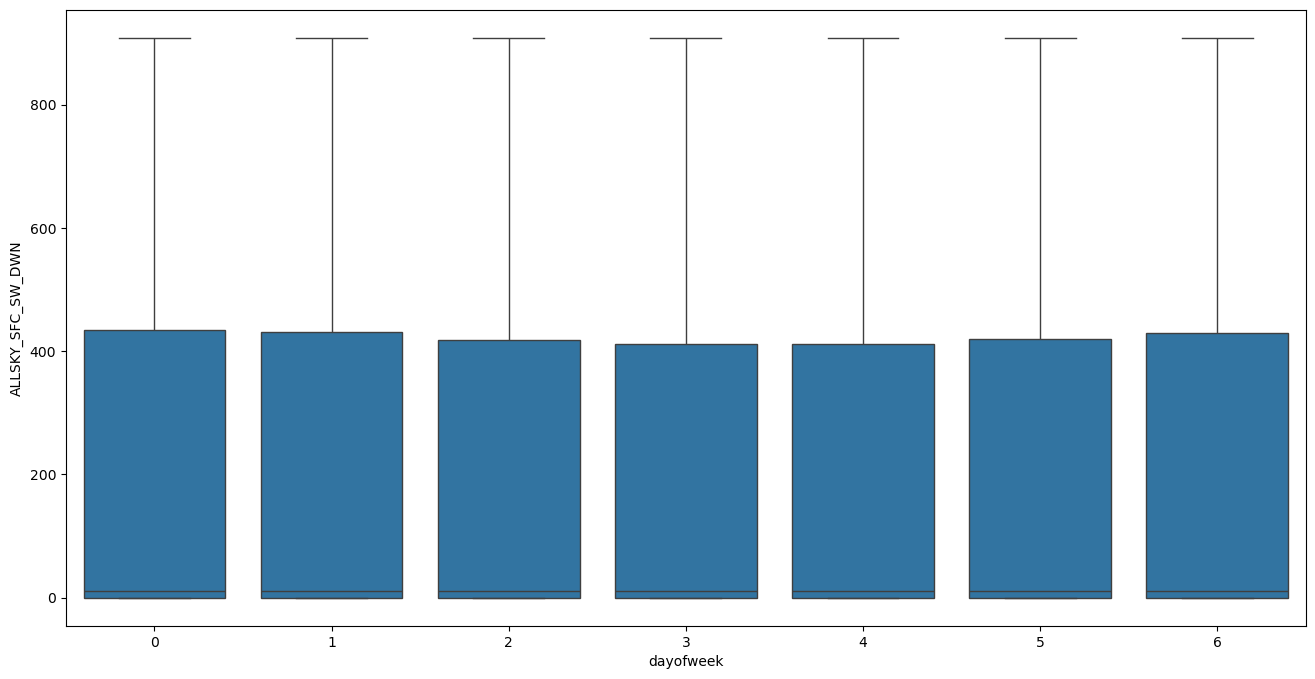

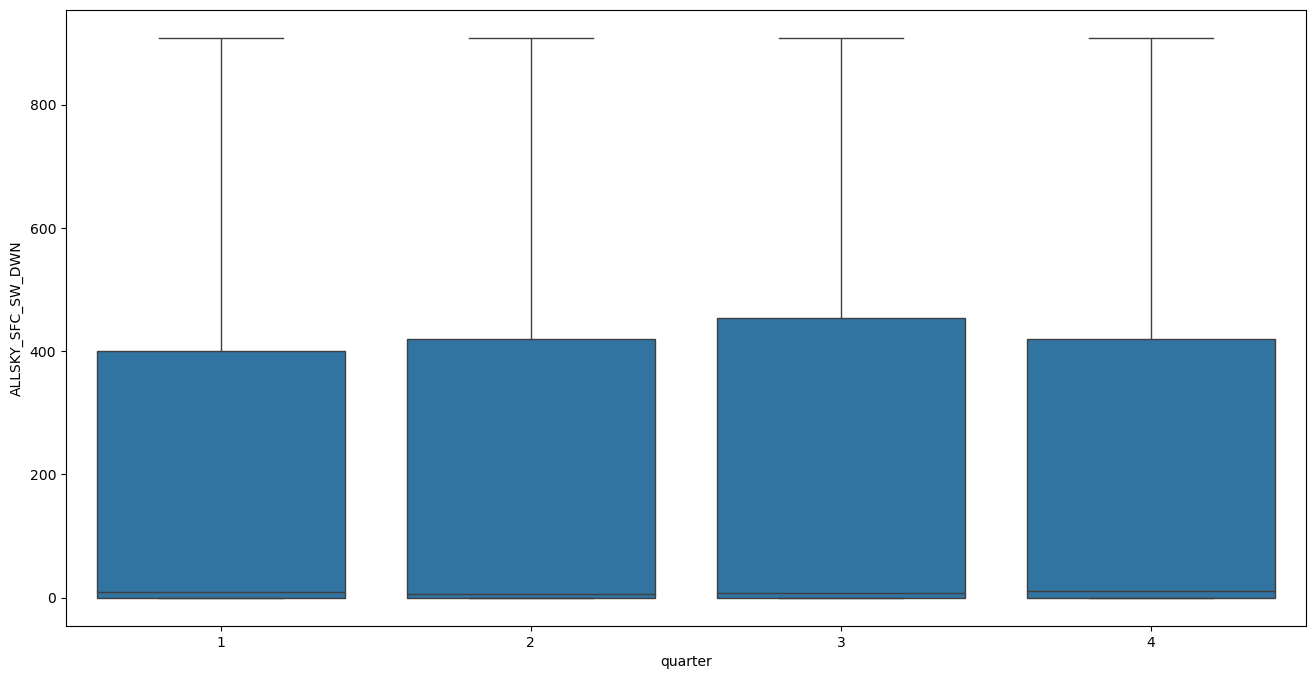

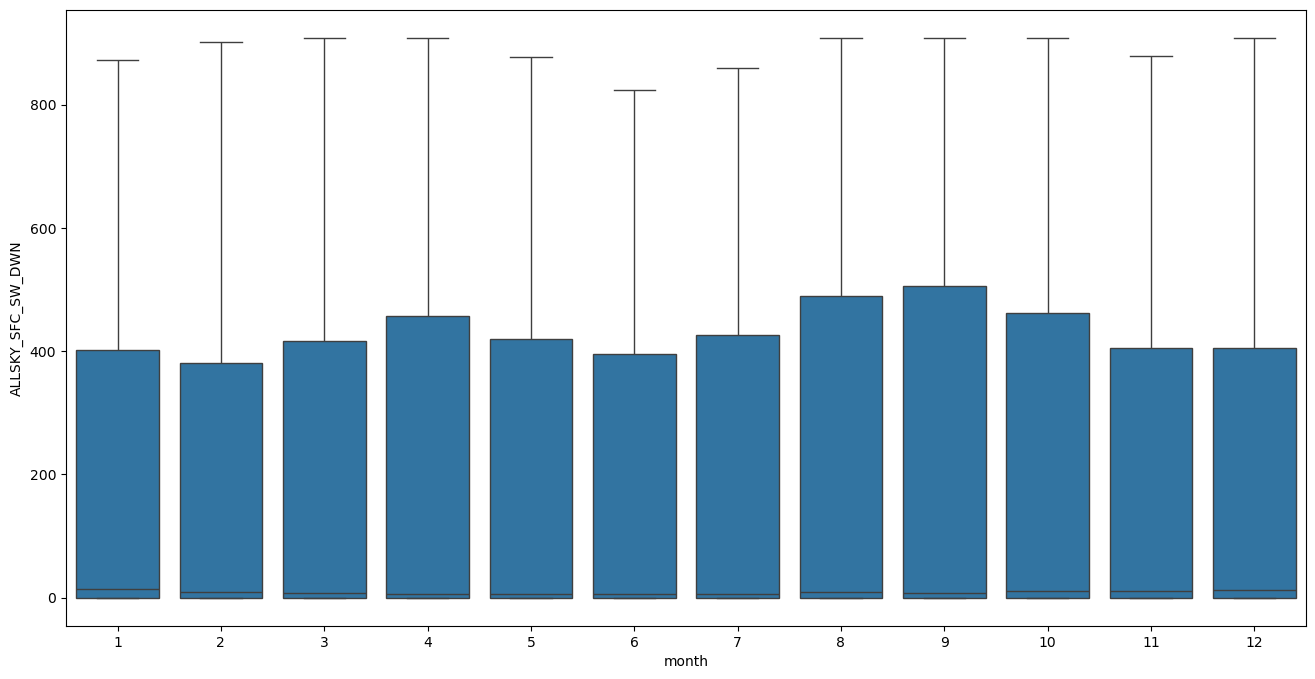

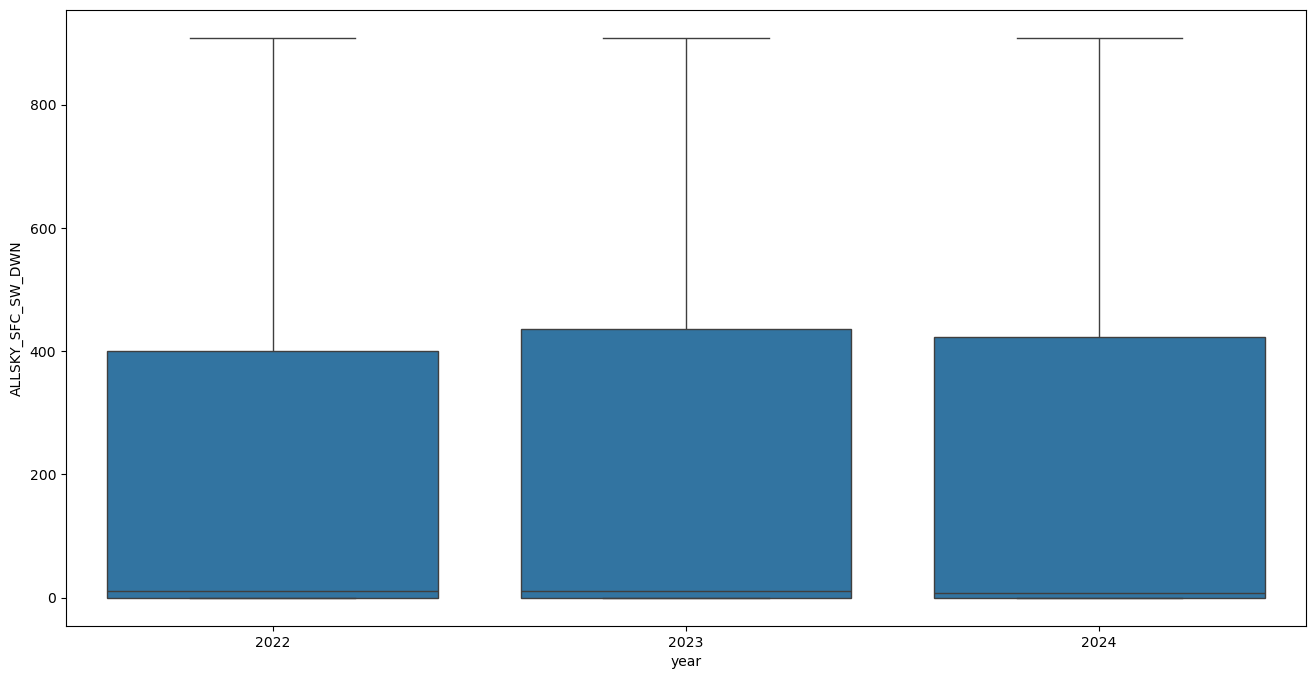

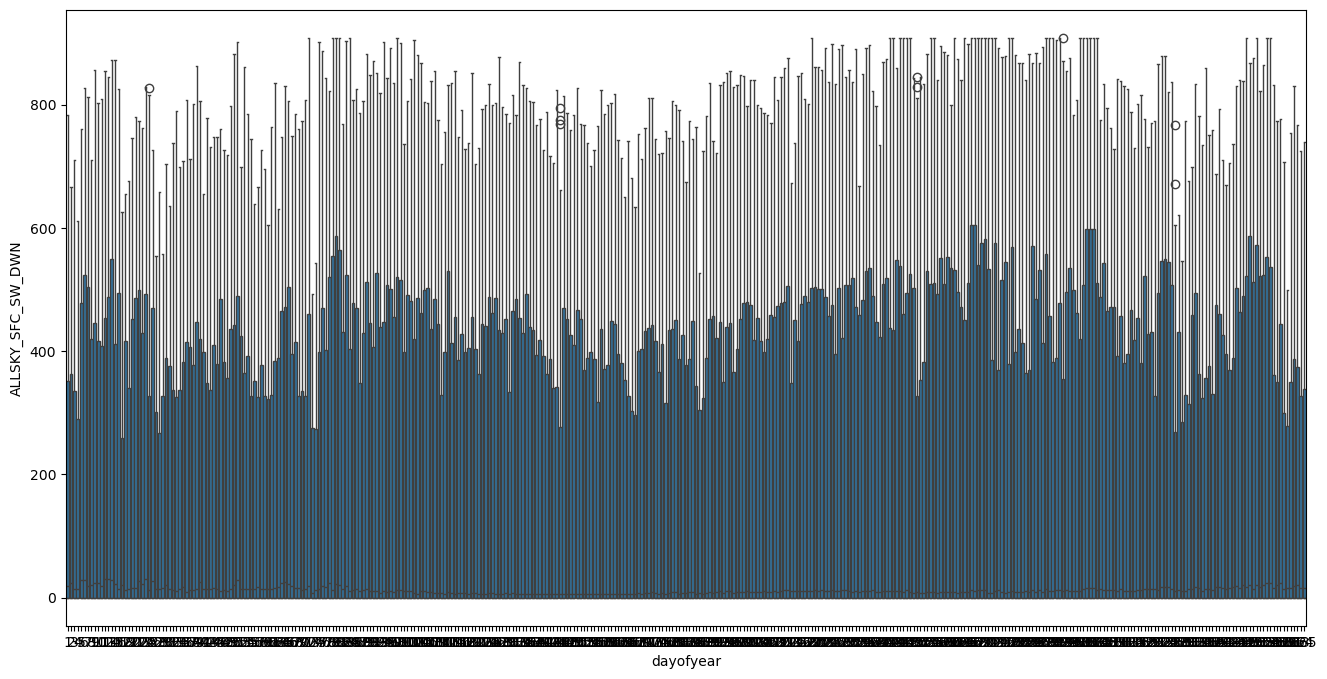

In [10]:
column = ['hour','dayofweek','quarter','month','year','dayofyear']
for i in column:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.boxplot(data=data_df, x =i,y='ALLSKY_SFC_SW_DWN')
  plt.show()

In [11]:
train = create_features(train)
test = create_features(test)

C:\Users\Acer\AppData\Local\Temp\ipykernel_12948\1483320389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\Acer\AppData\Local\Temp\ipykernel_12948\1483320389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
C:\Users\Acer\AppData\Local\Temp\ipykernel_12948\1483320389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [12]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear']
TARGET = 'ALLSKY_SFC_SW_DWN'

x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
y_pred = reg.predict(x_test)
y_pred

array([8.215031, 8.215031, 8.215031, ..., 6.67795 , 6.67795 , 6.67795 ],
      dtype=float32)

In [15]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 2856.935816917734
R-squared: 0.9609680710520689


In [16]:
test['prediction2'] = y_pred
last_df1 = data_df.merge(test['prediction2'], how='left', left_index=True, right_index=True)
last_df1

C:\Users\Acer\AppData\Local\Temp\ipykernel_12948\3783512210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction2'] = y_pred


,ALLSKY_SFC_SW_DWN,hour,dayofweek,quarter,month,year,dayofyear,prediction2
datetime,,,,,,,,
2022-03-27 00:00:00,0.0,0,6,1,3,2022,86,NaN
2022-03-27 01:00:00,0.0,1,6,1,3,2022,86,NaN
2022-03-27 02:00:00,0.0,2,6,1,3,2022,86,NaN
2022-03-27 03:00:00,0.0,3,6,1,3,2022,86,NaN
2022-03-27 04:00:00,0.0,4,6,1,3,2022,86,NaN
...,...,...,...,...,...,...,...,...
2024-07-29 19:00:00,0.0,19,0,3,7,2024,211,6.67795
2024-07-29 20:00:00,0.0,20,0,3,7,2024,211,6.67795
2024-07-29 21:00:00,0.0,21,0,3,7,2024,211,6.67795


In [17]:
last_df1.tail()

,ALLSKY_SFC_SW_DWN,hour,dayofweek,quarter,month,year,dayofyear,prediction2
datetime,,,,,,,,
2024-07-29 19:00:00,0.0,19,0,3,7,2024,211,6.67795
2024-07-29 20:00:00,0.0,20,0,3,7,2024,211,6.67795
2024-07-29 21:00:00,0.0,21,0,3,7,2024,211,6.67795
2024-07-29 22:00:00,0.0,22,0,3,7,2024,211,6.67795
2024-07-29 23:00:00,0.0,23,0,3,7,2024,211,6.67795


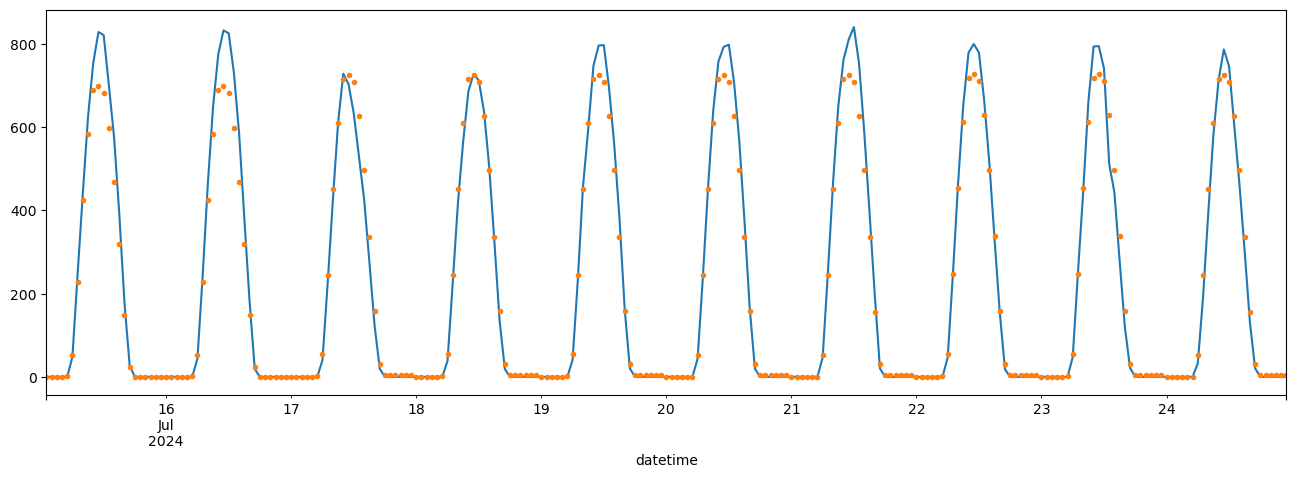

In [18]:
ax = last_df1.loc[(last_df1.index > '07-15-2024') & (last_df1.index < '07-25-2024')]['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df1.loc[(last_df1.index > '07-15-2024') & (last_df1.index < '07-25-2024')]['prediction2'].plot(ax=ax, style='.')
plt.show()

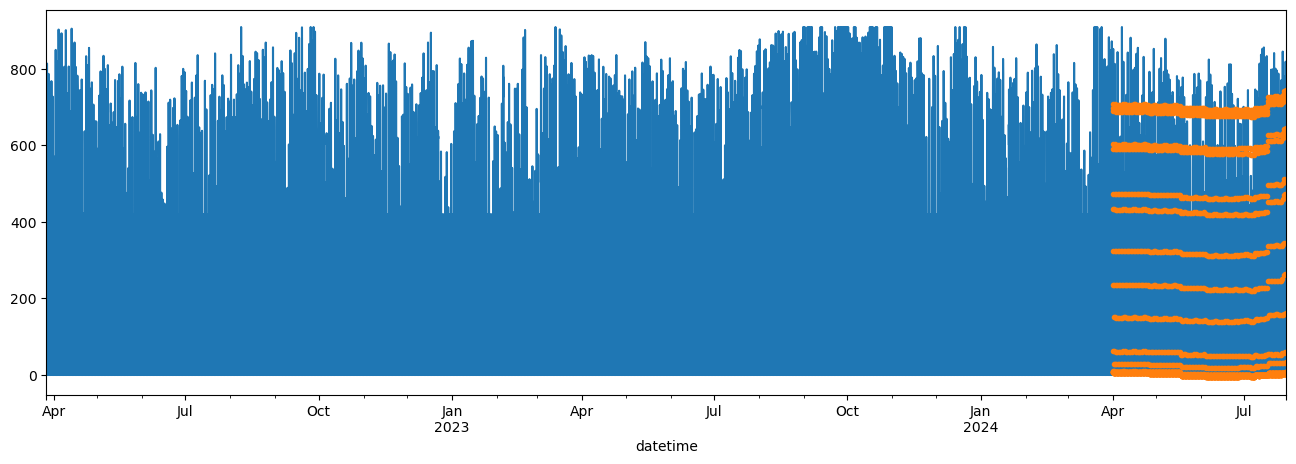

In [19]:
ax = last_df1['ALLSKY_SFC_SW_DWN'].plot(figsize=(16,5))
last_df1['prediction2'].plot(ax=ax, style='.')
plt.show()

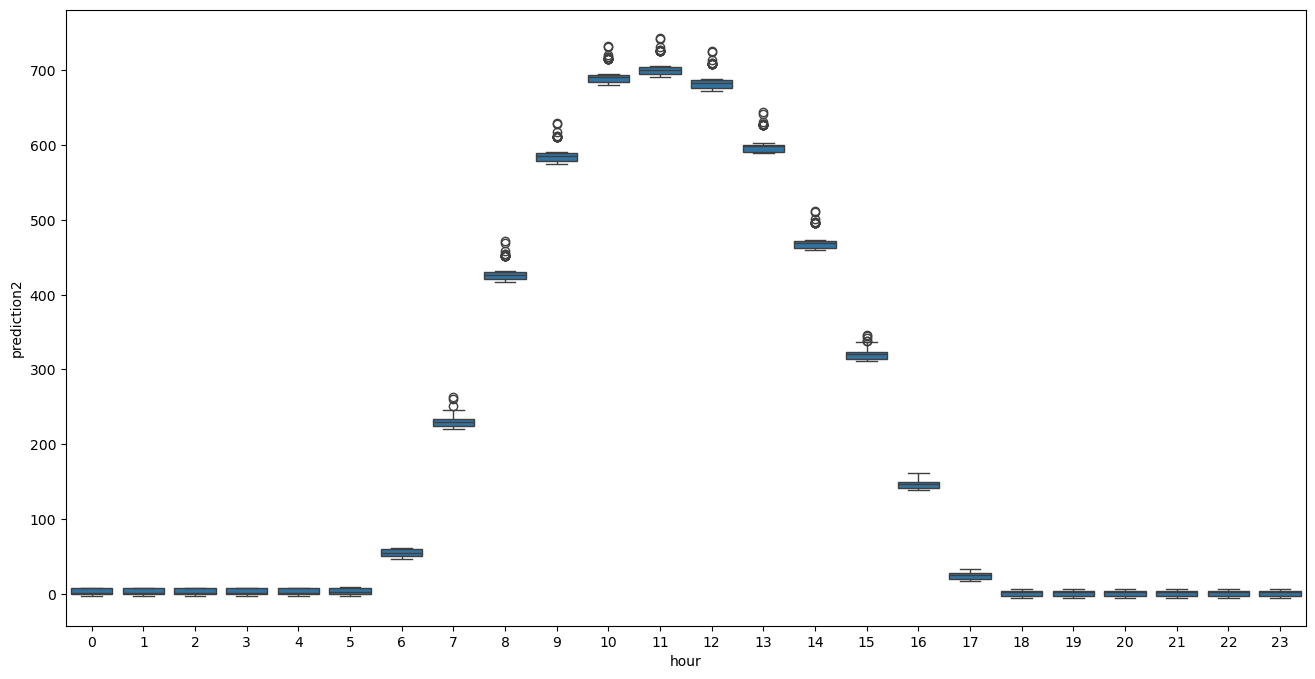

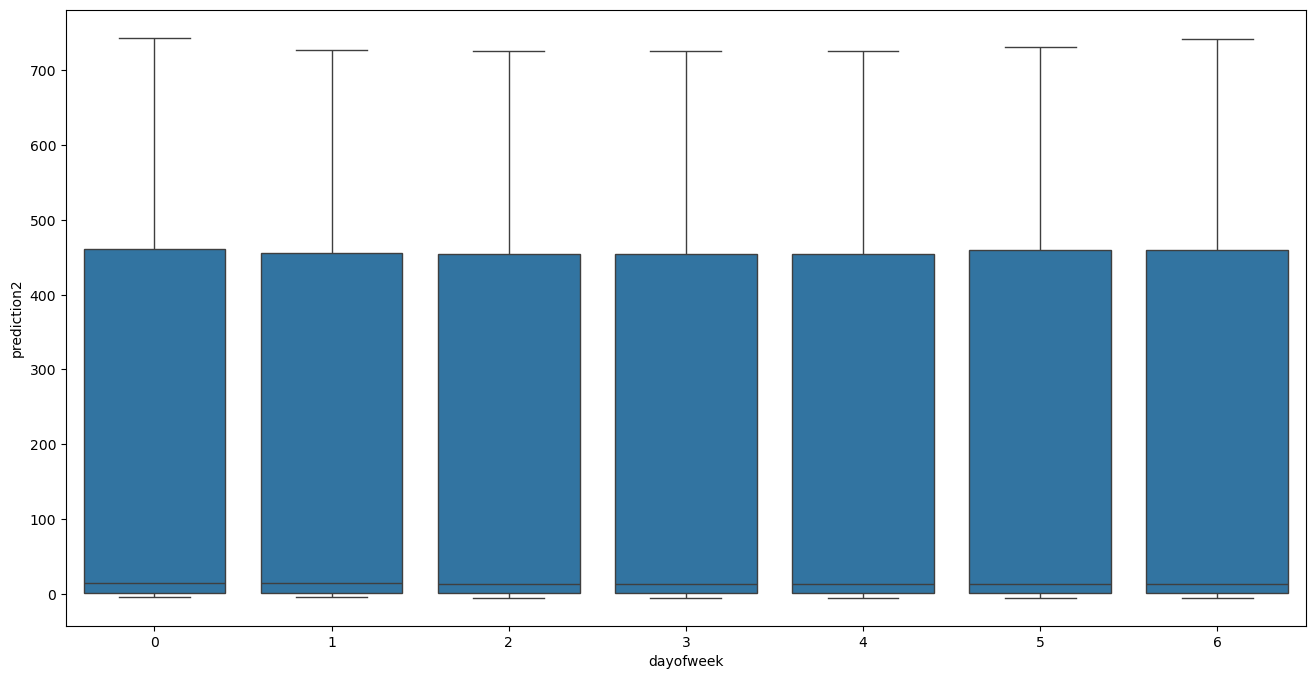

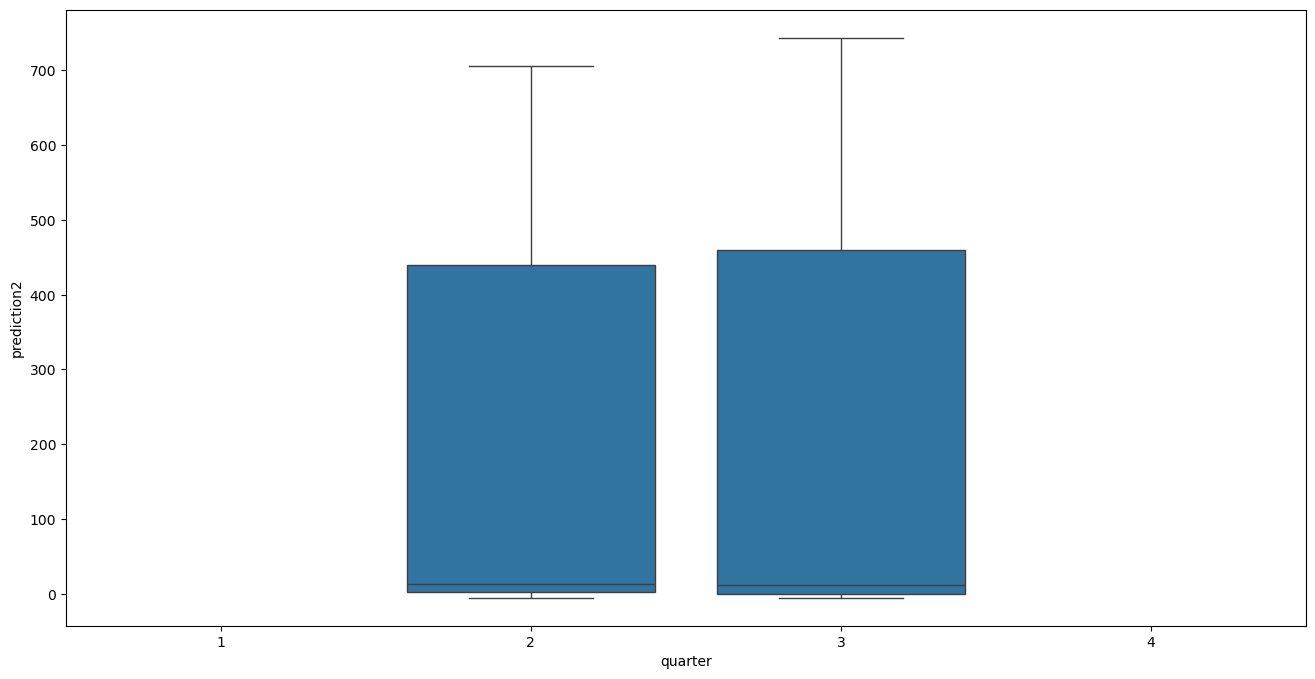

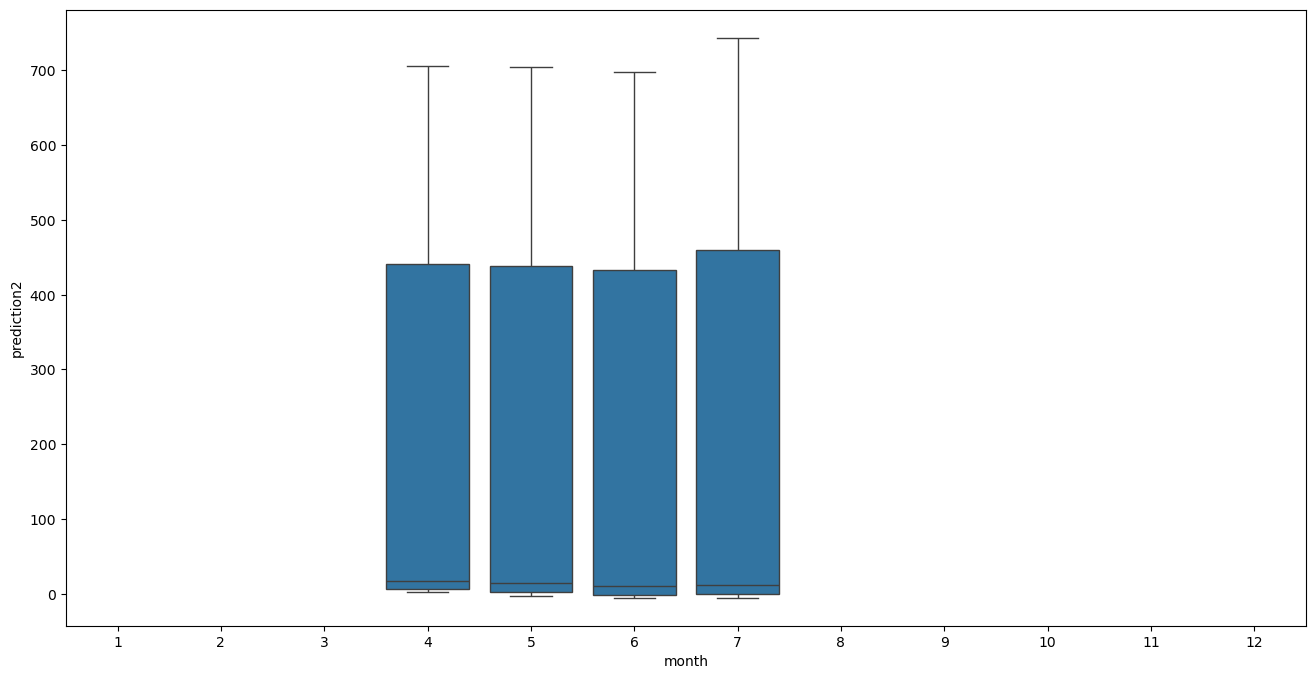

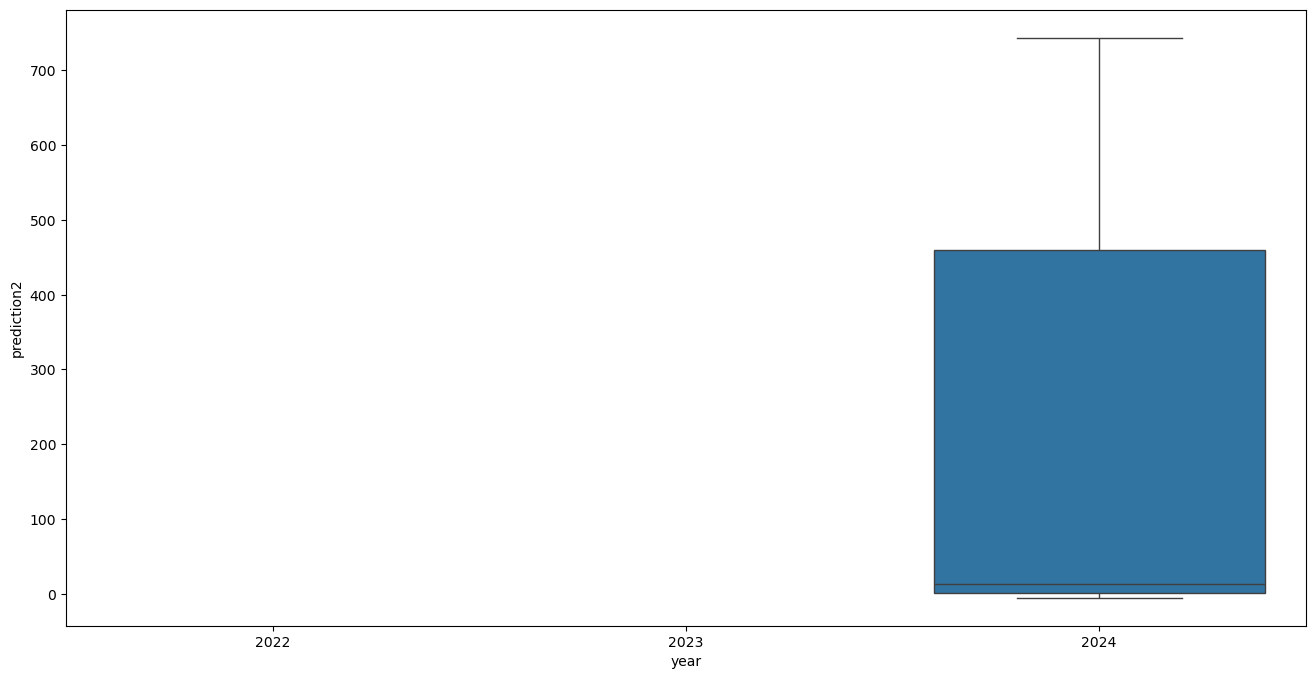

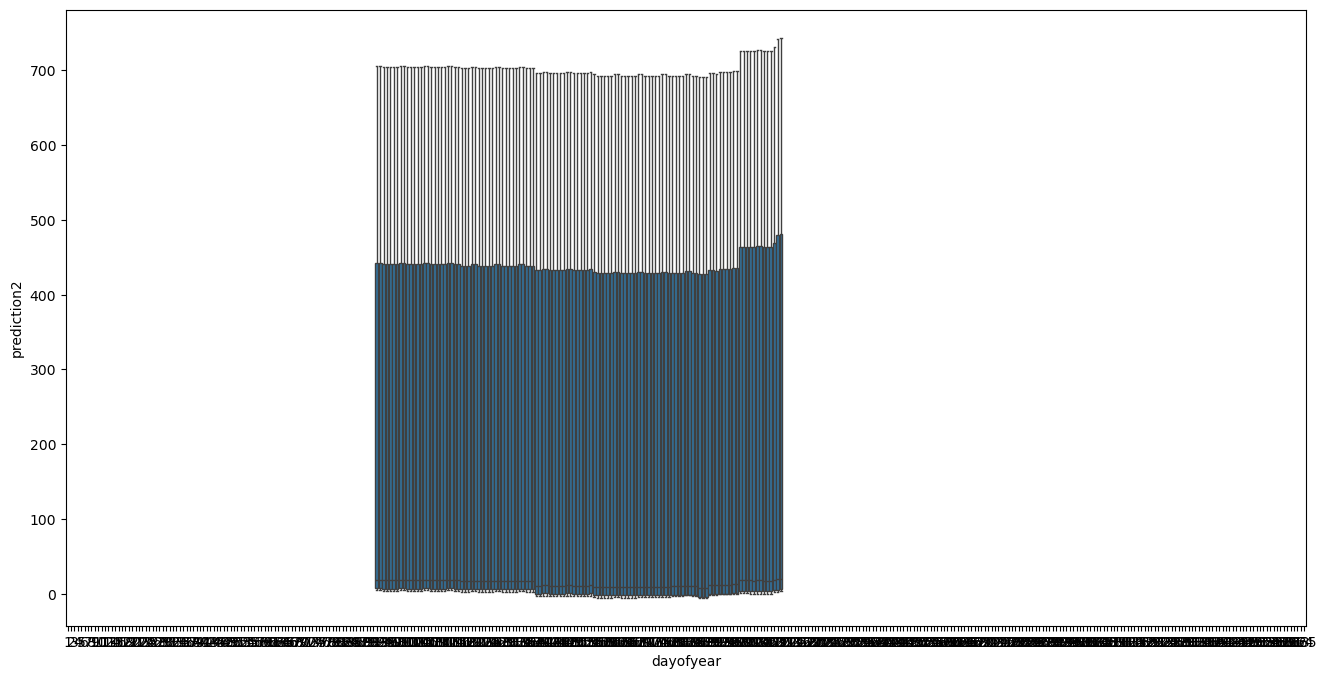

In [20]:
column = ['hour','dayofweek','quarter','month','year','dayofyear']
for i in column:
  fig, ax = plt.subplots(figsize=(16,8))
  sns.boxplot(data=last_df1, x =i,y='prediction2')
  plt.show()

In [21]:
file = pd.read_csv('Evaluation_Model_Score')
file

,model,r2_score,Mean Squared Error
0,Randomforest,0.926070,5307.576827
1,Randomforest gridsearch,0.936131,4585.293070


In [22]:
new_item = ({'model' : 'XGboost',
    'r2_score' : r2,
    'Mean Squared Error' : mse,
    })

In [23]:
import csv

In [25]:
fields=['XGBOOST',r2,mse]

with open('Evaluation_Model_Score', mode='a',newline='') as file :
    writter=csv.writer(file)
    writter.writerow(fields)

In [26]:
file = pd.read_csv('Evaluation_Model_Score')
file

,model,r2_score,Mean Squared Error
0,Randomforest,0.926070,5307.576827
1,Randomforest gridsearch,0.936131,4585.293070
2,XGBOOST,0.960968,2856.935817
